<a href="https://colab.research.google.com/github/Alisser2001/QuantumMachineLearning/blob/main/ElevatorshybridSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install optuna



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=c0107be741ddd3ea4a05864bf977e85f90090415a826b2980fa8d66508834a2f
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from qiskit import *
from qiskit.visualization import *
from qiskit_aer import *

#--- Pipeline final ------

In [ ]:
# ============================================================
# CQ-Optuna v9: Optuna por (modo × n_qubits) - 3 trials por configuración
# ============================================================
import os, time, requests, numpy as np, pandas as pd, matplotlib.pyplot as plt, optuna
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.visualization import circuit_drawer

# ---------------- CONFIG ----------------
RESULTS_DIR = "cq_v9_optuna_outputs"
os.makedirs(f"{RESULTS_DIR}/figs", exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/circuits", exist_ok=True)

QUBITS_LIST = [4, 6, 8, 10, 12]
MODES = ["Z", "Z+ZZ", "Pauli", "Angle", "Fourier", "RandomizedPauli"]
N_TRIALS = 3

# ---------------- DATASET ----------------
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [line.strip() for line in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]
df = pd.DataFrame(data, columns=attributes).astype(float)

X_full, y_full = df.drop(columns=["Goal"]).values, df["Goal"].values
sc_raw = StandardScaler().fit(X_full)
X_scaled = sc_raw.transform(X_full)
mask = LocalOutlierFactor(n_neighbors=20, contamination=0.05).fit_predict(X_scaled) == 1
X, y = X_full[mask], y_full[mask]
print(f"[LOF] Muestras: {len(df)} → {len(X)} (removidos {len(df)-len(X)})")

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
y_tr, y_te = np.log1p(y_tr), np.log1p(y_te)

# ---------------- UTILIDADES ----------------
def build_observables(n_qubits):
    paulis = []
    for i in range(n_qubits):
        mask = ["I"] * n_qubits
        mask[i] = "Z"
        paulis.append(SparsePauliOp("".join(mask)))
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            mask = ["I"] * n_qubits
            mask[i] = mask[j] = "Z"
            paulis.append(SparsePauliOp("".join(mask)))
    return paulis

def make_circuit(x, n, mode):
    if mode == "Z":
        qc = QuantumCircuit(n)
        for i,val in enumerate(x[:n]): qc.rz(float(val), i)
        return qc
    if mode == "Z+ZZ":
        fm = ZZFeatureMap(feature_dimension=n, reps=2, entanglement="full")
        return fm.assign_parameters(dict(zip(fm.parameters, x[:n])))
    if mode == "Pauli":
        fm = PauliFeatureMap(feature_dimension=n, reps=2, paulis=["X","Y","Z"])
        return fm.assign_parameters(dict(zip(fm.parameters, x[:n])))
    if mode == "Angle":
        qc = QuantumCircuit(n)
        for i,val in enumerate(x[:n]): qc.ry(float(val), i)
        for i in range(n-1): qc.cz(i,i+1)
        return qc
    if mode == "Fourier":
        qc = QuantumCircuit(n)
        for i,val in enumerate(x[:n]):
            qc.h(i); qc.rz(2*np.pi*float(val), i)
        for i in range(n-1): qc.cz(i,i+1)
        return qc
    if mode == "RandomizedPauli":
        qc = QuantumCircuit(n)
        rng = np.random.default_rng(42)
        for i,val in enumerate(x[:n]): qc.ry(float(val), i)
        for _ in range(2):
            for i in range(n): getattr(qc, rng.choice(["x","y","z"]))(i)
            for i in range(n-1): qc.cz(i,i+1)
        return qc
    raise ValueError(mode)

def circuit_metrics(qc):
    return {
        "depth": qc.depth(),
        "size": qc.size(),
        "multi_qubit_gates": sum(1 for g in qc.data if len(g.qubits)>1),
        "parameters": len(qc.parameters),
        "num_qubits": qc.num_qubits,
        "ops": qc.count_ops()
    }

def quantum_features(Xb, n_qubits, mode):
    paulis = build_observables(n_qubits)
    feats, qc_sample = [], None
    for x in Xb:
        qc = make_circuit(x, n_qubits, mode)
        if qc_sample is None: qc_sample = qc
        psi = Statevector.from_instruction(qc)
        feats.append([float(np.real(psi.expectation_value(p))) for p in paulis])
    return np.array(feats), qc_sample

# ---------------- EXPERIMENTO POR CONFIG ----------------
def run_experiment(mode, n_qubits, C, epsilon, kernel):
    scaler = StandardScaler().fit(X_tr)
    Xtr, Xte = scaler.transform(X_tr), scaler.transform(X_te)
    pca = PCA(n_components=n_qubits).fit(Xtr)
    Xtr_p, Xte_p = pca.transform(Xtr), pca.transform(Xte)

    t0 = time.time()
    Z_tr, qc_sample = quantum_features(Xtr_p, n_qubits, mode)
    Z_te, _ = quantum_features(Xte_p, n_qubits, mode)
    Xh_tr, Xh_te = np.hstack([Xtr_p,Z_tr]), np.hstack([Xte_p,Z_te])

    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    model.fit(Xh_tr, y_tr)
    y_pred = model.predict(Xh_te)
    elapsed = time.time() - t0

    return {
        "MSE": mean_squared_error(y_te, y_pred),
        "MAE": mean_absolute_error(y_te, y_pred),
        "R2": r2_score(y_te, y_pred),
        "time": elapsed,
        "qc_sample": qc_sample
    }

# ---------------- LOOP GLOBAL ----------------
records = []
for q in QUBITS_LIST:
    for mode in MODES:
        print(f"\n=== Optimizando {mode} con {q} qubits ===")

        def objective(trial):
            C = trial.suggest_float("C", 0.1, 10, log=True)
            epsilon = trial.suggest_float("epsilon", 0.01, 0.3)
            kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
            metrics = run_experiment(mode, q, C, epsilon, kernel)
            trial.set_user_attr("qc_sample", metrics["qc_sample"])
            trial.set_user_attr("time", metrics["time"])
            return metrics["MSE"]

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

        best = study.best_trial
        qc_best = best.user_attrs["qc_sample"]
        circ_data = circuit_metrics(qc_best)

        rec = {
            "mode": mode,
            "qubits": q,
            "best_MSE": best.value,
            "best_C": best.params["C"],
            "best_epsilon": best.params["epsilon"],
            "best_kernel": best.params["kernel"],
            "depth": circ_data["depth"],
            "size": circ_data["size"],
            "multi_qubit_gates": circ_data["multi_qubit_gates"],
            "num_qubits": circ_data["num_qubits"],
            "ops": circ_data["ops"],
            "time": best.user_attrs["time"]
        }
        records.append(rec)
        print(f"→ Mejor trial: MSE={rec['best_MSE']:.6f}, "
              f"kernel={rec['best_kernel']}, C={rec['best_C']:.3f}, eps={rec['best_epsilon']:.3f}")

# ---------------- RESULTADOS ----------------
df = pd.DataFrame(records)
df.to_csv(f"{RESULTS_DIR}/cq_v9_best_results.csv", index=False)
print("\n[OK] Resultados guardados:", f"{RESULTS_DIR}/cq_v9_best_results.csv")
print(df[["mode","qubits","best_MSE","best_kernel","best_C","best_epsilon","depth","multi_qubit_gates"]])

# ---------------- PLOTS ----------------
plt.figure(figsize=(10,6))
for m in MODES:
    sub = df[df.mode==m].sort_values("qubits")
    plt.plot(sub.qubits, sub.best_MSE, marker='o', label=m)
plt.title("Mejor MSE por modo y nº de qubits (Optuna 3 trials)")
plt.xlabel("Qubits"); plt.ylabel("MSE"); plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/figs/mse_vs_qubits_best.png", dpi=160)
plt.show()


✅ Resultados extraídos:
           mode  qubits      MSE kernel     C  epsilon
          Pauli       4 0.000143   poly 1.345    0.021
          Angle       4 0.000150    rbf 2.987    0.019
              Z       4 0.000455 linear 0.282    0.094
           Z+ZZ       4 0.000455 linear 0.138    0.210
        Fourier       4 0.000455   poly 0.114    0.174
RandomizedPauli       4 0.000455 linear 1.556    0.143
        Fourier       6 0.000057    rbf 1.858    0.014
              Z       6 0.000455 linear 3.461    0.186
           Z+ZZ       6 0.000455   poly 2.481    0.205
          Pauli       6 0.000455    rbf 8.632    0.191
          Angle       6 0.000455   poly 3.209    0.183
RandomizedPauli       6 0.000455   poly 0.844    0.243
              Z       8 0.000455 linear 1.004    0.190
           Z+ZZ       8 0.000455   poly 2.326    0.204
          Pauli       8 0.000455   poly 0.870    0.248
          Angle       8 0.000455   poly 3.013    0.095
        Fourier       8 0.000455   poly 0

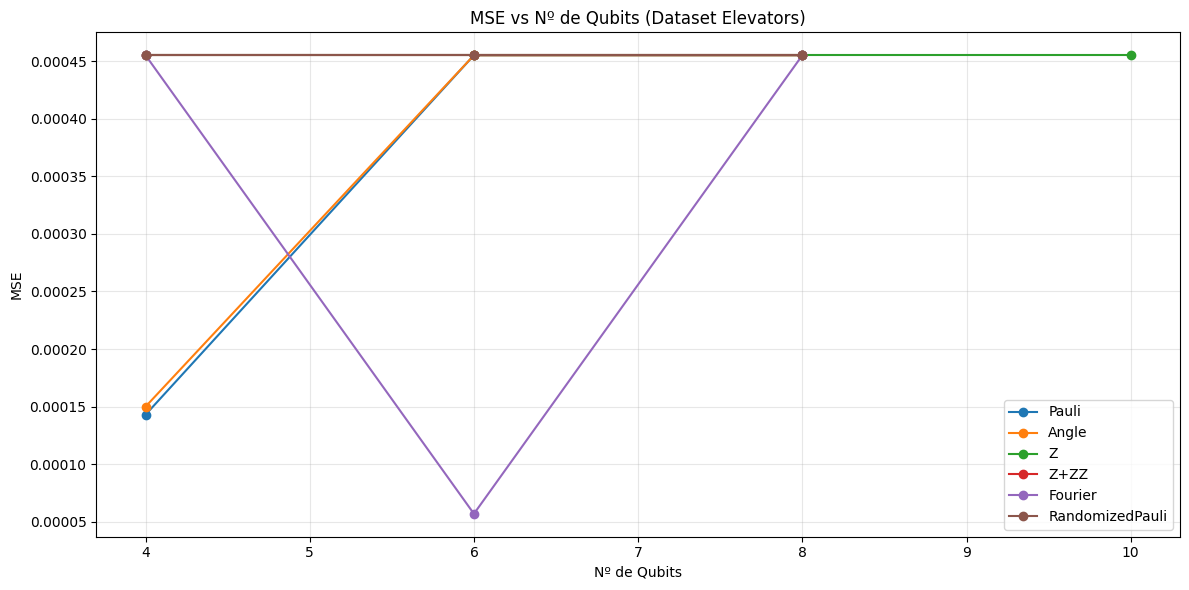

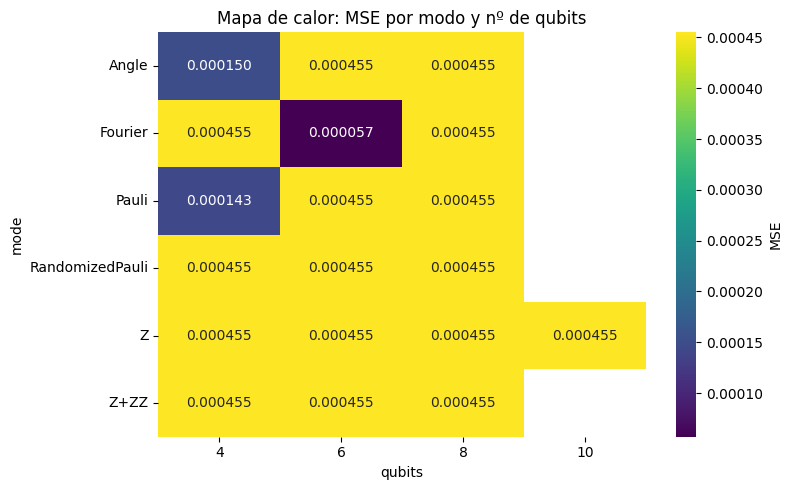

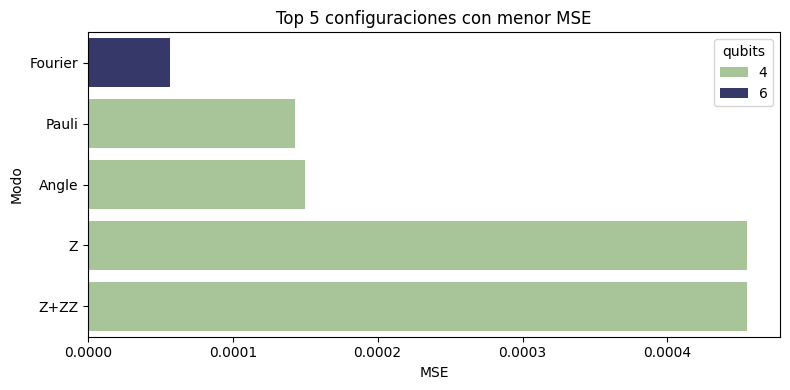

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Pega aquí tu log completo (todo el texto desde === Optimizando ... hasta el final)
log_text = """
=== Optimizando Z con 4 qubits ===
[I 2025-11-10 02:26:19,727] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 0.28185093477907436, 'epsilon': 0.0939218748192267, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:26:39,825] Trial 1 finished with value: 0.00045519083772952416 and parameters: {'C': 3.608491193023057, 'epsilon': 0.1491267416835447, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:26:58,795] Trial 2 finished with value: 0.0004551908377295251 and parameters: {'C': 2.65310204338609, 'epsilon': 0.2512660538829378, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:26:58,797] A new study created in memory with name: no-name-dbaf31b6-b1ba-4b81-bdbf-ee5ec1176494
→ Mejor trial: MSE=0.000455, kernel=linear, C=0.282, eps=0.094

=== Optimizando Z+ZZ con 4 qubits ===
[I 2025-11-10 02:30:38,485] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 1.8030154793434474, 'epsilon': 0.07182482787318946, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:34:14,658] Trial 1 finished with value: 0.0004551908377295239 and parameters: {'C': 0.13778996213692907, 'epsilon': 0.21047899386908261, 'kernel': 'linear'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 02:37:48,170] Trial 2 finished with value: 0.0004551908377295246 and parameters: {'C': 3.5044691922893025, 'epsilon': 0.21911578479433497, 'kernel': 'rbf'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 02:37:48,172] A new study created in memory with name: no-name-01a99a91-54f0-45df-90ca-e34cf9d58d96
→ Mejor trial: MSE=0.000455, kernel=linear, C=0.138, eps=0.210

=== Optimizando Pauli con 4 qubits ===
[I 2025-11-10 02:41:24,032] Trial 0 finished with value: 0.0004551908377295239 and parameters: {'C': 1.0513277970669654, 'epsilon': 0.2316554914616217, 'kernel': 'linear'}. Best is trial 0 with value: 0.0004551908377295239.
[I 2025-11-10 02:45:00,473] Trial 1 finished with value: 0.0004551908377295246 and parameters: {'C': 0.5080391518099475, 'epsilon': 0.030018048170136133, 'kernel': 'linear'}. Best is trial 0 with value: 0.0004551908377295239.
[I 2025-11-10 02:48:35,873] Trial 2 finished with value: 0.00014323098880737945 and parameters: {'C': 1.3449504592060595, 'epsilon': 0.020785264818079546, 'kernel': 'poly'}. Best is trial 2 with value: 0.00014323098880737945.
[I 2025-11-10 02:48:35,875] A new study created in memory with name: no-name-6a217a22-ca21-443b-9573-89aeb7cf3c9c
→ Mejor trial: MSE=0.000143, kernel=poly, C=1.345, eps=0.021

=== Optimizando Angle con 4 qubits ===
[I 2025-11-10 02:48:58,956] Trial 0 finished with value: 0.00014978554598543754 and parameters: {'C': 2.9867780441892346, 'epsilon': 0.01945309626239909, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00014978554598543754.
[I 2025-11-10 02:49:21,824] Trial 1 finished with value: 0.0004551908377295246 and parameters: {'C': 1.5772430086811262, 'epsilon': 0.19943038579272426, 'kernel': 'poly'}. Best is trial 0 with value: 0.00014978554598543754.
[I 2025-11-10 02:49:44,345] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 1.877304602205373, 'epsilon': 0.1403125929754128, 'kernel': 'poly'}. Best is trial 0 with value: 0.00014978554598543754.
[I 2025-11-10 02:49:44,348] A new study created in memory with name: no-name-83729b97-bc8d-479a-9f45-ecb465a490a9
→ Mejor trial: MSE=0.000150, kernel=rbf, C=2.987, eps=0.019

=== Optimizando Fourier con 4 qubits ===
[I 2025-11-10 02:50:11,227] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 0.11364777926317152, 'epsilon': 0.17361782932136, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:50:37,516] Trial 1 finished with value: 0.00045519083772952416 and parameters: {'C': 8.119102848599901, 'epsilon': 0.07153084282268407, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:51:03,769] Trial 2 finished with value: 0.0004551908377295246 and parameters: {'C': 0.16735390371815642, 'epsilon': 0.12302299928919778, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:51:03,771] A new study created in memory with name: no-name-df1e518c-5a0a-46b6-a35c-9cb631ec0405
→ Mejor trial: MSE=0.000455, kernel=poly, C=0.114, eps=0.174

=== Optimizando RandomizedPauli con 4 qubits ===
[I 2025-11-10 02:51:41,027] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 1.5563431795587104, 'epsilon': 0.14250080729696316, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:52:18,136] Trial 1 finished with value: 0.00045519083772952416 and parameters: {'C': 7.036330277277345, 'epsilon': 0.10249249981017587, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:52:55,571] Trial 2 finished with value: 0.0004551908377295251 and parameters: {'C': 0.806798172414866, 'epsilon': 0.28125179136243195, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:52:55,573] A new study created in memory with name: no-name-08303c1b-0893-460c-b9d7-ff493bb9bed2
→ Mejor trial: MSE=0.000455, kernel=linear, C=1.556, eps=0.143

=== Optimizando Z con 6 qubits ===
[I 2025-11-10 02:53:26,865] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 3.461369295429021, 'epsilon': 0.1862941674606744, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:53:58,995] Trial 1 finished with value: 0.0004551908377295246 and parameters: {'C': 0.1080773989933756, 'epsilon': 0.21449444372831183, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:54:30,253] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 1.20548410689834, 'epsilon': 0.117177197576808, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 02:54:30,255] A new study created in memory with name: no-name-e8c1888a-3ad7-44b6-bf5c-3bb5bbcc546f
→ Mejor trial: MSE=0.000455, kernel=linear, C=3.461, eps=0.186

=== Optimizando Z+ZZ con 6 qubits ===
[I 2025-11-10 03:00:58,152] Trial 0 finished with value: 0.0004551908377295246 and parameters: {'C': 0.17379421841746454, 'epsilon': 0.032923075411643556, 'kernel': 'rbf'}. Best is trial 0 with value: 0.0004551908377295246.
[I 2025-11-10 03:07:28,087] Trial 1 finished with value: 0.0004551908377295239 and parameters: {'C': 2.4805905245359514, 'epsilon': 0.20520643545495357, 'kernel': 'poly'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 03:13:57,020] Trial 2 finished with value: 0.0004551908377295239 and parameters: {'C': 0.13353904807683362, 'epsilon': 0.2082097245165104, 'kernel': 'linear'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 03:13:57,022] A new study created in memory with name: no-name-20b65092-d271-4a9c-813b-1a8f8695d018
→ Mejor trial: MSE=0.000455, kernel=poly, C=2.481, eps=0.205

=== Optimizando Pauli con 6 qubits ===
[I 2025-11-10 03:19:00,480] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 8.631736039810189, 'epsilon': 0.19129331051895465, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:24:05,220] Trial 1 finished with value: 0.0004551908377295251 and parameters: {'C': 0.3487816566552809, 'epsilon': 0.24692499097112558, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:29:08,425] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 1.9060365484862762, 'epsilon': 0.16237570354374006, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:29:08,427] A new study created in memory with name: no-name-e0d84368-bdfc-428a-9011-160801d7f119
→ Mejor trial: MSE=0.000455, kernel=rbf, C=8.632, eps=0.191

=== Optimizando Angle con 6 qubits ===
[I 2025-11-10 03:29:45,302] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 3.209169635321243, 'epsilon': 0.18285962571348038, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:30:21,543] Trial 1 finished with value: 0.00045519083772952416 and parameters: {'C': 0.6237039791685671, 'epsilon': 0.17649808864374847, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:30:58,074] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 0.1549665645364675, 'epsilon': 0.1183961663662125, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:30:58,075] A new study created in memory with name: no-name-ae5d6044-d19f-47f4-b345-872e96457471
→ Mejor trial: MSE=0.000455, kernel=poly, C=3.209, eps=0.183

=== Optimizando Fourier con 6 qubits ===
[I 2025-11-10 03:31:41,065] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 1.8364798523879087, 'epsilon': 0.18536304193023273, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:32:22,921] Trial 1 finished with value: 0.0004551908377295246 and parameters: {'C': 0.42230534233286077, 'epsilon': 0.21557924468982037, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:33:05,573] Trial 2 finished with value: 5.664981526315766e-05 and parameters: {'C': 1.857586062349808, 'epsilon': 0.01448553398795667, 'kernel': 'rbf'}. Best is trial 2 with value: 5.664981526315766e-05.
[I 2025-11-10 03:33:05,576] A new study created in memory with name: no-name-c7c876ab-ca5d-4979-b5af-ce3e63e19521
→ Mejor trial: MSE=0.000057, kernel=rbf, C=1.858, eps=0.014

=== Optimizando RandomizedPauli con 6 qubits ===
[I 2025-11-10 03:34:03,983] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 7.931271884581265, 'epsilon': 0.09129253236006767, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:35:02,693] Trial 1 finished with value: 0.0004551908377295239 and parameters: {'C': 0.8438565650650067, 'epsilon': 0.24257702525458932, 'kernel': 'poly'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 03:36:00,375] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 0.31204706656476666, 'epsilon': 0.1463844986807163, 'kernel': 'poly'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 03:36:00,378] A new study created in memory with name: no-name-f86836fe-8a17-4928-a275-8d60b9fae1db
→ Mejor trial: MSE=0.000455, kernel=poly, C=0.844, eps=0.243

=== Optimizando Z con 8 qubits ===
[I 2025-11-10 03:36:47,698] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 1.003565254363391, 'epsilon': 0.1897297888352653, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:37:34,683] Trial 1 finished with value: 0.0004551908377295251 and parameters: {'C': 0.11919692567776853, 'epsilon': 0.26297596450712796, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:38:20,905] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 2.9650574265888126, 'epsilon': 0.0631144461648868, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 03:38:20,907] A new study created in memory with name: no-name-31253079-7f97-408c-9070-7189d8e50b7d
→ Mejor trial: MSE=0.000455, kernel=linear, C=1.004, eps=0.190

=== Optimizando Z+ZZ con 8 qubits ===
[I 2025-11-10 03:48:58,219] Trial 0 finished with value: 0.0004551908377295246 and parameters: {'C': 0.3256776315752489, 'epsilon': 0.21202295972963586, 'kernel': 'rbf'}. Best is trial 0 with value: 0.0004551908377295246.
[I 2025-11-10 03:59:35,215] Trial 1 finished with value: 0.0004551908377295246 and parameters: {'C': 0.33565408239612415, 'epsilon': 0.21542925165881577, 'kernel': 'linear'}. Best is trial 0 with value: 0.0004551908377295246.
[I 2025-11-10 04:10:12,252] Trial 2 finished with value: 0.0004551908377295239 and parameters: {'C': 2.326429262414066, 'epsilon': 0.20424850543060744, 'kernel': 'poly'}. Best is trial 2 with value: 0.0004551908377295239.
[I 2025-11-10 04:10:12,254] A new study created in memory with name: no-name-393d208c-cae1-4ffe-bd98-ec7169ab706c
→ Mejor trial: MSE=0.000455, kernel=poly, C=2.326, eps=0.204

=== Optimizando Pauli con 8 qubits ===
[I 2025-11-10 04:16:49,614] Trial 0 finished with value: 0.0004551908377295246 and parameters: {'C': 8.827647562348789, 'epsilon': 0.04660754102253478, 'kernel': 'linear'}. Best is trial 0 with value: 0.0004551908377295246.
[I 2025-11-10 04:23:26,633] Trial 1 finished with value: 0.0004551908377295239 and parameters: {'C': 0.8695737315411483, 'epsilon': 0.24834022268909975, 'kernel': 'poly'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 04:30:03,660] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 4.704482782133545, 'epsilon': 0.08531668944986477, 'kernel': 'rbf'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 04:30:03,662] A new study created in memory with name: no-name-09316659-e079-42e1-bd2f-986e5c298681
→ Mejor trial: MSE=0.000455, kernel=poly, C=0.870, eps=0.248

=== Optimizando Angle con 8 qubits ===
[I 2025-11-10 04:30:57,491] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 3.013053162850071, 'epsilon': 0.09509552115991042, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:31:51,274] Trial 1 finished with value: 0.00045519083772952416 and parameters: {'C': 1.1348125767231598, 'epsilon': 0.1900763296296305, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:32:45,982] Trial 2 finished with value: 0.0004551908377295246 and parameters: {'C': 0.2182371177098619, 'epsilon': 0.034225101111123084, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:32:45,984] A new study created in memory with name: no-name-93bc6aa3-84c8-46d6-b50e-9c9429cea22d
→ Mejor trial: MSE=0.000455, kernel=poly, C=3.013, eps=0.095

=== Optimizando Fourier con 8 qubits ===
[I 2025-11-10 04:33:46,876] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 0.42997749431393706, 'epsilon': 0.195617811852634, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:34:48,621] Trial 1 finished with value: 0.00045519083772952416 and parameters: {'C': 0.13662374328762247, 'epsilon': 0.06700214696403096, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:35:50,024] Trial 2 finished with value: 0.0004551908377295246 and parameters: {'C': 0.5286601916060263, 'epsilon': 0.037522388945552466, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:35:50,026] A new study created in memory with name: no-name-5d44aa44-37d1-4b08-aca9-c2b2de92f0da
→ Mejor trial: MSE=0.000455, kernel=poly, C=0.430, eps=0.196

=== Optimizando RandomizedPauli con 8 qubits ===
[I 2025-11-10 04:37:14,473] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 6.425772390256789, 'epsilon': 0.17906388110574464, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:38:37,865] Trial 1 finished with value: 0.0004551908377295239 and parameters: {'C': 8.100531028781578, 'epsilon': 0.24854406473552434, 'kernel': 'poly'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 04:40:02,030] Trial 2 finished with value: 0.0004551908377295251 and parameters: {'C': 0.9667427269887349, 'epsilon': 0.27284171478896696, 'kernel': 'rbf'}. Best is trial 1 with value: 0.0004551908377295239.
[I 2025-11-10 04:40:02,033] A new study created in memory with name: no-name-1b51078e-1ea4-4c54-b194-ce34a7ab54ff
→ Mejor trial: MSE=0.000455, kernel=poly, C=8.101, eps=0.249

=== Optimizando Z con 10 qubits ===
[I 2025-11-10 04:41:09,719] Trial 0 finished with value: 0.00045519083772952416 and parameters: {'C': 0.4108236184459725, 'epsilon': 0.1753307983251745, 'kernel': 'poly'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:42:18,273] Trial 1 finished with value: 0.0004551908377295246 and parameters: {'C': 0.11175265289928926, 'epsilon': 0.03704886277095019, 'kernel': 'rbf'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:43:26,333] Trial 2 finished with value: 0.00045519083772952416 and parameters: {'C': 0.38498828693614523, 'epsilon': 0.14703252136746173, 'kernel': 'linear'}. Best is trial 0 with value: 0.00045519083772952416.
[I 2025-11-10 04:43:26,335] A new study created in memory with name: no-name-e9182b6d-88e3-40ef-be42-4c6f239eccb3
→ Mejor trial: MSE=0.000455, kernel=poly, C=0.411, eps=0.175

=== Optimizando Z+ZZ con 10 qubits ===
[I 2025-11-10 04:59:48,480] Trial 0 finished with value: 0.0004551908377295246 and parameters: {'C': 0.3652437278044434, 'epsilon': 0.05771534737139112, 'kernel': 'rbf'}. Best is trial 0 with value: 0.0004551908377295246.
[I 2025-11-10 05:16:13,693] Trial 1 finished with value: 0.00045519083772952416 and parameters: {'C': 0.6809085656833167, 'epsilon': 0.06541958354686919, 'kernel': 'linear'}. Best is trial 1 with value: 0.00045519083772952416.

"""  # ← Pega aquí TODO el log completo (puedes incluir 10 qubits aunque haya terminado abruptamente)

# 1️⃣ Extraer secciones
blocks = re.split(r"=== Optimizando ", log_text)
data = []

for b in blocks[1:]:
    try:
        # Extraer modo y qubits
        header = b.split(" ===")[0]
        mode, q = re.match(r"(.+?) con (\d+) qubits", header).groups()
        q = int(q)

        # Extraer mejor trial
        best = re.search(r"MSE=([\d\.eE\-]+), kernel=([a-z]+), C=([\d\.]+), eps=([\d\.]+)", b)
        if best:
            mse, kernel, C, eps = best.groups()
            data.append({
                "mode": mode.strip(),
                "qubits": q,
                "MSE": float(mse),
                "kernel": kernel,
                "C": float(C),
                "epsilon": float(eps)
            })
    except Exception as e:
        print("Error parsing block:", e)

# 2️⃣ Crear DataFrame ordenado
df = pd.DataFrame(data)
df.sort_values(["qubits","MSE"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Resultados extraídos:")
print(df.to_string(index=False))

# 3️⃣ Graficar MSE vs qubits
plt.figure(figsize=(12,6))
for m in df["mode"].unique():
    sub = df[df["mode"]==m].sort_values("qubits")
    plt.plot(sub["qubits"], sub["MSE"], marker='o', label=m)
plt.title("MSE vs Nº de Qubits (Dataset Elevators)")
plt.xlabel("Nº de Qubits")
plt.ylabel("MSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4️⃣ Heatmap modo vs qubits
plt.figure(figsize=(8,5))
pivot = df.pivot(index="mode", columns="qubits", values="MSE")
sns.heatmap(pivot, annot=True, fmt=".6f", cmap="viridis", cbar_kws={"label":"MSE"})
plt.title("Mapa de calor: MSE por modo y nº de qubits")
plt.tight_layout()
plt.show()

# 5️⃣ Top 5 mejores resultados
top5 = df.nsmallest(5, "MSE")
plt.figure(figsize=(8,4))
sns.barplot(x="MSE", y="mode", hue="qubits", data=top5, palette="crest")
plt.title("Top 5 configuraciones con menor MSE")
plt.xlabel("MSE")
plt.ylabel("Modo")
plt.tight_layout()
plt.show()


In [ ]:

import time, requests, numpy as np, pandas as pd
from typing import List, Dict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import Statevector, SparsePauliOp

# ------------------------ CONFIG ------------------------
QUBITS_LIST = [4, 6, 8, 10, 12]
MODES = ["Z", "Z+ZZ", "Pauli", "Angle", "Fourier", "RandomizedPauli"]
np.set_printoptions(precision=4, suppress=True)

# ------------------------ DATASET ------------------------
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat
resp = requests.get(url)
lines = [line.strip() for line in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]
df = pd.DataFrame(data, columns=attributes).astype(float)

X_full = df.drop(columns=["Salary"]).values
y_full = df["Salary"].values

sc_raw = StandardScaler().fit(X_full)
X_scaled = sc_raw.transform(X_full)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
mask = lof.fit_predict(X_scaled) == 1
X, y = X_full[mask], y_full[mask]
print(f"\n[LOF] Muestras originales: {len(df)} → {len(X)} (removidos {len(df)-len(X)})\n")

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
y_tr, y_te = np.log1p(y_tr), np.log1p(y_te)

# ------------------------ OBSERVABLES ------------------------
def build_observables(n_qubits: int, include_pairs: bool = True) -> List[SparsePauliOp]:
    paulis = []
    for i in range(n_qubits):
        mask = ["I"] * n_qubits; mask[i] = "Z"
        paulis.append(SparsePauliOp("".join(mask)))
    if include_pairs:
        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                mask = ["I"] * n_qubits; mask[i] = mask[j] = "Z"
                paulis.append(SparsePauliOp("".join(mask)))
    return paulis

# ------------------------ FEATURE MAPS ------------------------
def circuit_z(x, n): qc=QuantumCircuit(n); [qc.rz(float(v),i) for i,v in enumerate(x[:n])]; return qc
def circuit_z_zz(x,n): fm=ZZFeatureMap(n,reps=2,entanglement="full"); return fm.assign_parameters(dict(zip(fm.parameters,x[:n])))
def circuit_pauli(x,n): fm=PauliFeatureMap(n,reps=2,paulis=["X","Y","Z"]); return fm.assign_parameters(dict(zip(fm.parameters,x[:n])))
def circuit_angle(x,n): qc=QuantumCircuit(n); [qc.ry(float(v),i) for i,v in enumerate(x[:n])]; [qc.cz(i,i+1) for i in range(n-1)]; return qc
def circuit_fourier(x,n): qc=QuantumCircuit(n); [qc.h(i) or qc.rz(2*np.pi*float(v),i) for i,v in enumerate(x[:n])]; [qc.cz(i,i+1) for i in range(n-1)]; return qc
def circuit_random_pauli(x,n,reps=2,seed=42):
    rng=np.random.default_rng(seed); qc=circuit_angle(x,n)
    for _ in range(reps):
        for i in range(n): getattr(qc, rng.choice(["x","y","z"]))(i)
        [qc.cz(i,i+1) for i in range(n-1)]
    return qc

# ------------------------ CIRCUIT METRICS ------------------------
def circuit_metrics(qc: QuantumCircuit) -> Dict:
    return dict(
        depth=qc.depth(),
        size=qc.size(),
        multi_qubit_gates=sum(1 for g in qc.data if len(g.qubits)>1),
        parameters=len(qc.parameters),
        num_qubits=qc.num_qubits,
    )

# ------------------------ QUANTUM FEATURES ------------------------
def quantum_features(Xb, n_qubits, mode):
    paulis = build_observables(n_qubits)
    feats, qc_sample = [], None
    for x in Xb:
        if mode=="Z": qc=circuit_z(x,n_qubits)
        elif mode=="Z+ZZ": qc=circuit_z_zz(x,n_qubits)
        elif mode=="Pauli": qc=circuit_pauli(x,n_qubits)
        elif mode=="Angle": qc=circuit_angle(x,n_qubits)
        elif mode=="Fourier": qc=circuit_fourier(x,n_qubits)
        elif mode=="RandomizedPauli": qc=circuit_random_pauli(x,n_qubits)
        else: raise ValueError(f"Modo no soportado: {mode}")
        if qc_sample is None: qc_sample = qc
        psi = Statevector.from_instruction(qc)
        feats.append([float(np.real(psi.expectation_value(p))) for p in paulis])
    return np.array(feats), qc_sample

# ------------------------ RUN EXPERIMENT ------------------------
def run_one(mode, n_qubits):
    scaler = StandardScaler().fit(X_tr)
    X_tr_s, X_te_s = scaler.transform(X_tr), scaler.transform(X_te)
    pca = PCA(n_components=n_qubits).fit(X_tr_s)
    X_tr_p, X_te_p = pca.transform(X_tr_s), pca.transform(X_te_s)
    t0 = time.time()

    Z_tr, qc_sample = quantum_features(X_tr_p, n_qubits, mode)
    Z_te, _ = quantum_features(X_te_p, n_qubits, mode)
    Xh_tr, Xh_te = np.hstack([X_tr_p,Z_tr]), np.hstack([X_te_p,Z_te])

    model = Ridge(alpha=0.05).fit(Xh_tr, y_tr)
    y_pred = model.predict(Xh_te)
    elapsed = time.time()-t0

    metrics = {
        "mode": mode,
        "qubits": n_qubits,
        "MSE": mean_squared_error(y_te,y_pred),
        "MAE": mean_absolute_error(y_te,y_pred),
        "R2": r2_score(y_te,y_pred),
        "time": elapsed
    }
    metrics.update(circuit_metrics(qc_sample))
    return metrics

# ------------------------ MAIN LOOP ------------------------
results=[]
print("="*70)
print(f"{'EMBEDDING':<18}{'QUBITS':<8}{'MSE':<12}{'MAE':<12}{'R²':<10}{'TIME(s)':<10}{'DEPTH':<8}{'MULTI-QB':<10}")
print("="*70)
for q in QUBITS_LIST:
    for m in MODES:
        res = run_one(m,q)
        results.append(res)
        print(f"{m:<18}{q:<8}{res['MSE']:<12.6f}{res['MAE']:<12.6f}{res['R2']:<10.4f}{res['time']:<10.2f}{res['depth']:<8}{res['multi_qubit_gates']:<10}")
print("="*70)

df = pd.DataFrame(results)

# ------------------------ TOP CONFIGURACIONES ------------------------
print("\n=== Mejores configuraciones por MSE ===")
top = df.sort_values("MSE").groupby("mode").first().sort_values("MSE")
print(top[["qubits","MSE","R2","depth","size","multi_qubit_gates"]].to_string(float_format="%.5f"))
best = top.iloc[0]
print(f"\n>>> Mejor modelo absoluto: {best.name} ({best.qubits} qubits) - MSE={best.MSE:.5f}, R²={best.R2:.5f}")

# ------------------------ MÉTRICAS DE EFICIENCIA ------------------------
df["E1_simple"] = 1 / df["MSE"]
df["E2_rel"] = (1 / df["MSE"]) / (df["depth"] + df["multi_qubit_gates"])
df["E3_quantum"] = df["R2"] / (df["depth"] * (1 + df["multi_qubit_gates"]))
df["E4_cost_precision"] = df["MSE"] * (df["depth"] * (1 + df["multi_qubit_gates"]))
df["E5_speed"] = (1 / df["MSE"]) / df["time"]
df["E_global"] = df["R2"] / (df["MSE"] * df["depth"] * (1 + df["multi_qubit_gates"]))

# Métrica global de rendimiento (basada en MSE y tiempo)
df["performance_score"] = (1 / df["MSE"]) / (1 + np.log1p(df["time"]))

# ------------------------ RANKING DE EFICIENCIA ------------------------
ranking = df.sort_values("E3_quantum", ascending=False)
print("\n=== Ranking de eficiencia cuántica (E3 y E_global) ===")
cols = ["mode","qubits","MSE","R2","depth","multi_qubit_gates","E3_quantum","E_global","performance_score"]
print(ranking[cols].head(10).to_string(index=False, float_format="%.5f"))

best_eff = ranking.iloc[0]
print(f"\n>>> Modelo más eficiente: {best_eff['mode']} ({best_eff['qubits']} qubits)")
print(f"MSE={best_eff['MSE']:.5f} | R²={best_eff['R2']:.5f} | E3={best_eff['E3_quantum']:.5f} | E_global={best_eff['E_global']:.5f}")
print(f"Rendimiento general (performance_score): {best_eff['performance_score']:.5f}")

# ------------------------ PROMEDIOS GLOBALES ------------------------
summary = df.groupby("mode")[["MSE","R2","E_global","performance_score"]].mean().sort_values("performance_score",ascending=False)
print("\n=== Promedio de rendimiento general por embedding ===")
print(summary.to_string(float_format="%.5f"))
